##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 사전 학습된 ConvNet을 이용한 전이 학습

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a>   </td>
</table>

이 튜토리얼에서는 사전 훈련된 네트워크에서 전이 학습을 사용하여 고양이와 개의 이미지를 분류하는 방법을 배우게 됩니다.

사전 훈련된 모델은 이전에 대규모 데이터셋에서 훈련된 저장된 네트워크로, 일반적으로 대규모 이미지 분류 작업에서 훈련된 것입니다. 사전 훈련된 모델을 그대로 사용하거나 전이 학습을 사용하여 이 모델을 주어진 작업으로 사용자 정의하세요.

이미지 분류를 위한 전이 학습을 직관적인 시각에서 바라보면 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 시각 세계의 일반적인 모델로서 기능할 것이라는 점입니다. 그런 다음 대규모 데이터셋에서 대규모 모델을 교육하여 처음부터 시작할 필요 없이 이러한 학습된 특징 맵을 활용할 수 있습니다.

이번 notebook에서는 사전 훈련된 모델을 사용자 정의하는 두 가지 방법을 시도 해보겠습니다.:

1. 특성 추출: 새 샘플에서 의미 있는 특성을 추출하기 위해 이전 네트워크에서 학습한 표현을 사용합니다. 사전 훈련된 모델 위에 처음부터 훈련할 새 분류자를 추가하기만 하면 이전에 데이터세트로 학습한 특성 맵의 용도를 재사용할 수 있습니다.

전체 모델을 재훈련시킬 필요는 없습니다. 기본 컨볼루션 네트워크에는 그림 분류에 일반적으로 유용한 기능이 이미 포함되어 있습니다. 그러나 사전 훈련된 모델의 최종 분류 부분은 기존의 분류 작업에 따라 다르며 이후에 모델이 훈련된 클래스 집합에 따라 다릅니다.

1. 미세 조정: 고정된 기본 모델의 일부 최상위 층을 고정 해제하고 새로 추가 된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시킵니다. 이를 통해 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 보다 관련성이 있도록 할 수 있습니다.

일반적인 기계 학습 일련의 과정을 진행합니다.

1. 데이터 검사 및 이해
2. 입력 파이프 라인 빌드(이 경우 Keras ImageDataGenerator를 사용)
3. 모델 작성
    - 사전 훈련된 기본 모델(또한 사전 훈련된 가중치)에 적재
    - 분류 레이어를 맨 위에 쌓기
4. 모델 훈련
5. 모델 평가


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 데이터 전처리

### 데이터 다운로드

이 튜토리얼에서는 수천 개의 고양이와 개의 이미지가 포함된 데이터세트를 사용합니다. 이미지가 포함된 zip 파일을 다운로드하여 추출은 다음 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 훈련 및 검증을 위한 `tf.data.Dataset`를 생성합니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/load_data/images)에서 이미지 로드에 대해 자세히 알아볼 수 있습니다.

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


훈련용 데이터셋에서 처음 두 개의 이미지 및 레이블을 보여줍니다:

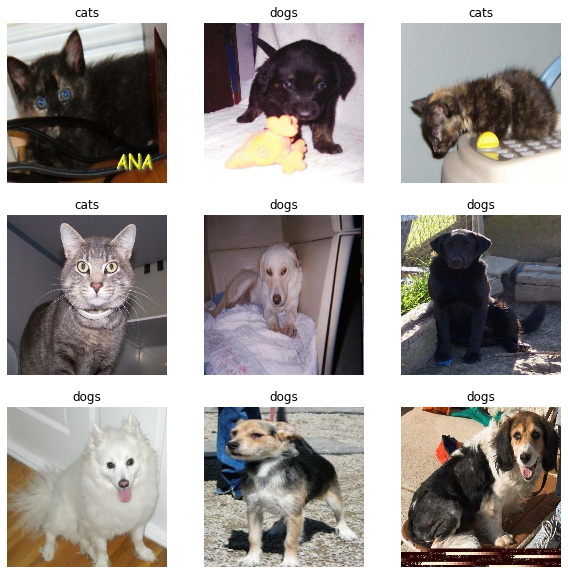

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

원본 데이터세트에는 테스트 세트가 포함되어 있지 않으므로 테스트 세트를 생성합니다. `tf.data.experimental.cardinality`를 사용하여 검증 세트에서 사용할 수 있는 데이터 배치 수를 확인한 다음 그 중 20%를 테스트 세트로 이동합니다.

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 이미지를 로드합니다. 이 방법에 대해 자세히 알아보려면 [데이터 성능](https://www.tensorflow.org/guide/data_performance) 가이드를 참조하세요.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강 사용

큰 이미지 데이터세트가 없는 경우, 회전 및 수평 뒤집기와 같이 훈련 이미지에 무작위이지만 사실적인 변환을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다. 이것은 모델을 훈련 데이터의 다양한 측면에 노출시키고 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)을 줄이는 데 도움이 됩니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/data_augmentation)에서 데이터 증강에 대해 자세히 알아볼 수 있습니다.

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

참고: `model.fit`을 호출할 때 훈련 중에만 이러한 레이어가 활성화됩니다. `model.evaulate` 또는 `model.fit`의 추론 모드에서 모델을 사용하면 비활성화됩니다.

같은 이미지에 이 레이어를 반복해서 적용하고 결과를 확인해 보겠습니다.

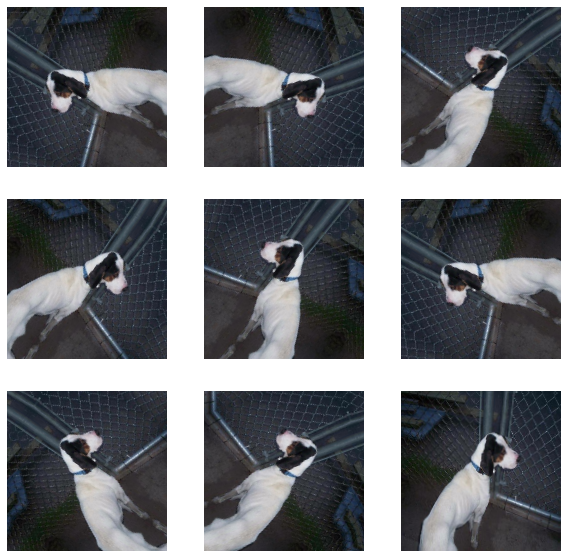

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 픽셀 값 재조정

잠시 후 기본 모델로 사용할 `tf.keras.applications.MobileNetV2`를 다운로드합니다. 이 모델은 `[-1, 1]`의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 `[0, 255]`입니다. 크기를 재조정하려면 모델에 포함된 전처리 메서드를 사용하세요.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

참고: 또는 `tf.keras.layers.Rescaling`을 사용하여 픽셀 값을 `[0, 255]`에서 `[-1, 1]`로 다시 조정할 수 있습니다.

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

참고: 다른 `tf.keras.applications`를 사용하는 경우 API 문서에서 `[-1, 1]` 또는 `[0, 1]`의 픽셀이 필요한지 확인하거나 포함된 `preprocess_input` 함수를 사용하세요.

## 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기

Google에서 개발한 MobileNet V2 모델로부터 기본 모델을 생성합니다. 이 모델은 1.4M 이미지와 1000개의 클래스로 구성된 대규모 데이터셋인 ImageNet 데이터셋를 사용해 사전 훈련된 모델입니다. ImageNet은 `잭프루트` 및 `주사기`와 같은 다양한 범주의 연구용 훈련 데이터셋입니다. 이 지식 기반은 특정 데이터셋에서 고양이와 개를 분류하는데 도움이 됩니다.

먼저 특성 추출에 사용할 MobileNet V2 레이어를 선택해야 합니다. 맨 마지막 분류 레이어("맨 위층", 대부분의 머신러닝 모델 다이어그램은 아래에서 위로 이동하므로)는 그리 유용하지 않습니다. 대신에 flatten 연산을 하기 전에 맨 마지막 레이어를 가지고 진행하겠습니다. 이 레이어를 "병목 레이어"라고 합니다. 병목 레이어 특성은 마지막/맨 위 레이어보다 일반성을 유지합니다.

먼저 ImageNet으로 훈련된 가중치가 저장된 MobileNet V2 모델을 인스턴스화 하세요. ** include_top = False ** 로 지정하면 맨 위에 분류 층이 포함되지 않은 네트워크를 로드하므로 특징 추출에 이상적입니다.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환합니다. 이미지 배치 예제에서 수행하는 작업을 확인하세요:

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 특징 추출

이 단계에서는 이전 단계에서 작성된 컨벌루션 베이스 모델을 동결하고 특징 추출기로 사용합니다. 또한 그 위에 분류기를 추가하고 최상위 분류기를 훈련시킵니다.

### 컨볼루션 베이스 모델 고정하기

모델을 컴파일하고 훈련하기 전에 컨볼루션 기반을 고정하는 것이 중요합니다. 동결(layer.trainable = False로 설정)은 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지합니다. MobileNet V2에는 많은 레이어가 있으므로 전체 모델의 `trainable` 플래그를 False로 설정하면 레이어가 모두 동결됩니다.

In [16]:
base_model.trainable = False

### BatchNormalization 레이어에 대한 중요 참고 사항

많은 모델에는 `tf.keras.layers.BatchNormalization` 레이어가 포함되어 있습니다. 이 레이어는 특별한 경우이며 이 튜토리얼의 뒷부분에 나와 있는 것처럼 미세 조정의 맥락에서 주의를 기울여야 합니다.

`layer.trainable = False`를 설정하면 `BatchNormalization` 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.

미세 조정을 위해 BatchNormalization 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 `training = False`를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 파괴됩니다.

자세한 내용은 [전이 학습 가이드](https://www.tensorflow.org/guide/keras/transfer_learning)를 참조하세요.

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### 분류 층을 맨 위에 추가하기

특성 블록에서 예측을 생성하기 위해 `tf.keras.layers.GlobalAveragePooling2D` 레이어를 사용하여 특성을 이미지당 하나의 1280-요소 벡터로 변환하여 `5x5` 공간 위치에 대한 평균을 구합니다.

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


`tf.keras.layers.Dense` 레이어를 사용하여 특성을 이미지당 단일 예측으로 변환합니다. 이 예측은 `logit`또는 원시 예측 값으로 취급되므로 활성화 함수가 필요하지 않습니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


[Keras Functional API](https://www.tensorflow.org/guide/keras/functional)를 사용하여 데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 함께 연결하여 모델을 구축합니다. 앞서 언급했듯이 모델에 BatchNormalization 레이어가 포함되어 있으므로 training=False를 사용하세요.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 모델 컴파일

모델을 훈련시키기 전에 컴파일합니다. 두 개의 클래스가 있고 모델이 선형 출력을 제공하므로 `from_logits=True`와 함께 `tf.keras.losses.BinaryCrossentropy` 손실을 사용합니다.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

MobileNet의 250만 매개변수는 고정되어 있지만 Dense 레이어에는 1200개의 *훈련 가능한* 매개변수가 있습니다. 이들은 두 개의 `tf.Variable` 객체, 즉 가중치와 편향으로 나뉩니다.

In [23]:
len(model.trainable_variables)

2

### 모델 훈련

10 epoch만큼 훈련한 후, 검증 세트에서 ~94%의 정확도를 볼 수 있습니다.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 44ms/step - loss: 0.7958 - accuracy: 0.4691


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.47


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 90ms/step - loss: 0.7589 - accuracy: 0.5350 - val_loss: 0.5547 - val_accuracy: 0.6498
Epoch 2/10
63/63 [==============================] - 5s 80ms/step - loss: 0.5593 - accuracy: 0.6855 - val_loss: 0.4004 - val_accuracy: 0.7686
Epoch 3/10
63/63 [==============================] - 5s 81ms/step - loss: 0.4512 - accuracy: 0.7630 - val_loss: 0.3155 - val_accuracy: 0.8441
Epoch 4/10
63/63 [==============================] - 5s 80ms/step - loss: 0.3714 - accuracy: 0.8190 - val_loss: 0.2496 - val_accuracy: 0.8824
Epoch 5/10
63/63 [==============================] - 5s 81ms/step - loss: 0.3270 - accuracy: 0.8420 - val_loss: 0.2187 - val_accuracy: 0.9084
Epoch 6/10
63/63 [==============================] - 5s 81ms/step - loss: 0.2948 - accuracy: 0.8605 - val_loss: 0.1830 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 5s 83ms/step - loss: 0.2739 - accuracy: 0.8770 - val_loss: 0.1673 - val_accuracy: 0.9394
Epoch 8/10
63

### 학습 곡선

MobileNet V2 기본 모델을 고정된 특징 추출기로 사용했을 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다.

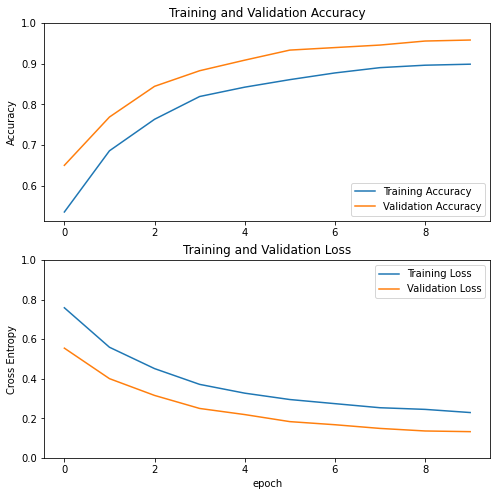

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: 유효성 검사 지표가 훈련 지표보다 명확하게 더 나은 이유는 `tf.keras.layers.BatchNormalization` 및 `tf.keras.layers.Dropout`과 같은 층이 훈련 중 정확도에 영향을 주기 때문입니다. 이것들은 유효성 검사 손실을 계산할 때 해제됩니다.

이보다는 적은 이유이겠지만, 훈련 메트릭이 한 epoch 동안의 평균을 평가하는 반면, 검증 메트릭은 epoch 이후에 평가되므로 검증 메트릭이 약간 더 오래 훈련된 모델을 볼 수 있기 때문입니다.

## 미세 조정

기능 추출 실험에서는 MobileNet V2 기본 모델을 기반으로 몇 개의 층 만 학습했습니다. 사전 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 **않았습니다**.

성능을 더욱 향상시키는 한 가지 방법은 추가 한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련(또는 "미세 조정")하는 것입니다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정됩니다.

Note: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 합니다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 됩니다.

또한 전체 MobileNet 모델이 아닌 소수의 최상위 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서 층이 높을수록 층이 더 전문화됩니다. 처음 몇 층은 거의 모든 유형의 이미지로 일반화되는 매우 간단하고 일반적인 특징을 학습합니다. 더 높은 수준으로 올라가면 훈련에 사용된 데이터 세트에 맞춰 특징이 점점 더 구체화 됩니다. 미세 조정의 목표는 이러한 전문화된 특징이 일반적인 학습을 덮어쓰지 않고 새 데이터셋에 맞춰 잘 동작 수 있도록 조정하는 것입니다.

### 최상위 층 고정 해제하기


base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### 모델 컴파일

훨씬 더 큰 모델을 훈련하고 있고 사전 훈련된 가중치를 다시 조정하려면 이 단계에서 낮은 학습률을 사용하는 것이 중요합니다. 그렇지 않으면 모델이 매우 빠르게 과대적합될 수 있습니다.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
len(model.trainable_variables)

56

### 모델 훈련 계속하기

이미 수렴 상태로 훈련된 경우에, 이 단계는 정확도를 몇 퍼센트 포인트 향상시킵니다.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 13s 105ms/step - loss: 0.1540 - accuracy: 0.9385 - val_loss: 0.0584 - val_accuracy: 0.9790
Epoch 11/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1197 - accuracy: 0.9495 - val_loss: 0.0463 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 6s 91ms/step - loss: 0.1070 - accuracy: 0.9550 - val_loss: 0.0444 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 6s 94ms/step - loss: 0.0920 - accuracy: 0.9640 - val_loss: 0.0459 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 6s 91ms/step - loss: 0.0892 - accuracy: 0.9645 - val_loss: 0.0473 - val_accuracy: 0.9765
Epoch 15/20
63/63 [==============================] - 6s 92ms/step - loss: 0.0833 - accuracy: 0.9670 - val_loss: 0.0486 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0696 - accuracy: 0.9710 - val_loss: 0.0361 - val_accuracy: 0.9814
Epo

MobileNet V2 기본 모델의 마지막 몇 층을 미세 조정하고 그 위의 분류기를 훈련할 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다. 검증 손실은 훈련 손실보다 훨씬 높으므로 약간의 과적합이 나올 수 있습니다.

새로운 훈련용 데이터셋이 상대적으로 작고 원래 MobileNet V2의 데이터셋과 유사하기 때문에 약간의 과적합이 발생할 수 있습니다.


미세 조정 후 모델은 거의 98% 정확도에 도달합니다.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

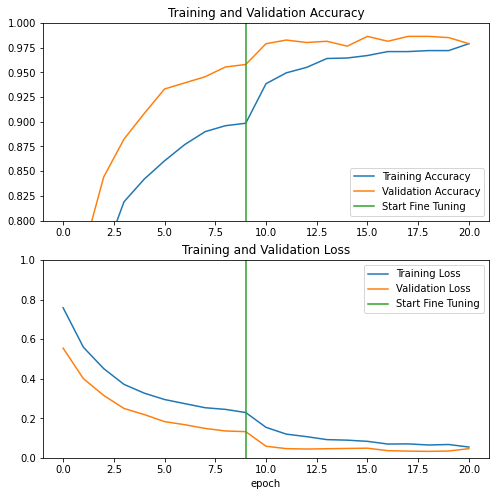

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 평가 및 예측

마지막으로 테스트 세트를 사용하여 새 데이터에 대한 모델의 성능을 확인할 수 있습니다.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 42ms/step - loss: 0.0562 - accuracy: 0.9688
Test accuracy : 0.96875


이제 이 모델을 사용하여 애완 동물이 고양이인지 개인지 예측할 준비가 되었습니다.

Predictions:
 [1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0]
Labels:
 [1 1 0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0]


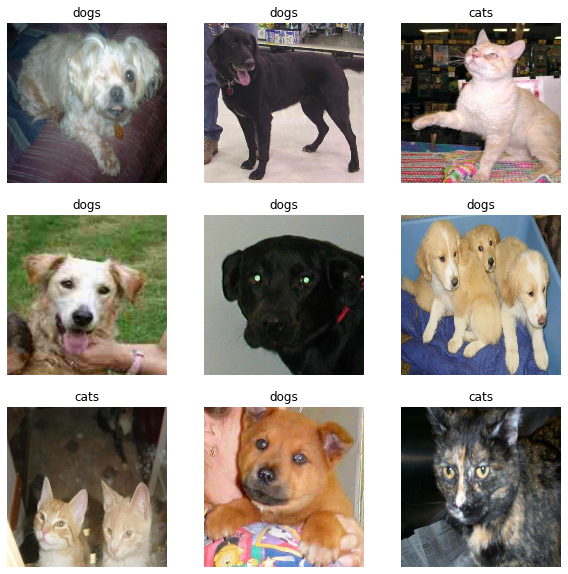

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 요약:

- **특징 추출을 위해 사전 훈련된 모델 사용하기**:  작은 데이터셋으로 작업 할 때는 동일한 범주의 클래스의 더 큰 데이터셋으로 훈련시킨 사전 학습된 모델의 특징을 활용하는 것이 일반적입니다. 사전 훈련된 모델을 인스턴스화하고 완전히 연결된 분류기를 맨 위에 추가하면 됩니다. 사전 훈련된 모델은 "고정"되고 분류기의 가중치만 훈련 중에 업데이트됩니다. 이 경우 컨벌루션 베이스 모델은 각 이미지와 관련된 모든 특징을 추출하며 주어진 추출된 특징을 가지고 이미지 클래스를 결정하는 분류기를 훈련합니다.

- **사전 훈련된 모델을 미세 조정하기**: 성능을 더욱 향상시키기 위해 사전 훈련된 모델의 최상위 계층을 미세 조정을 통해 새 데이터셋으로써 재사용 할 수 있습니다. 이 경우 모델이 주어진 데이터셋에 맞는 상위 레벨의 특징을 학습 할 수 있도록 가중치를 조정합니다. 이 기술은 일반적으로 훈련 데이터셋의 규모가 크고, 사전 훈련된 모델이 사용했던 원래 데이터셋과 매우 유사한 경우에 권장됩니다.

자세한 내용은 [전이 학습 가이드](https://www.tensorflow.org/guide/keras/transfer_learning)를 참조하십시오.
